# Separation

We evaluate different approaches:



1.   Unrolling RNN until nozzle-array
2.   Letting the RNN predict the intersection with the nozzle-array



In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

TensorFlow 2.x selected.


In [0]:
!wget pollithy.com/Pfeffer.zip
!unzip -q Pfeffer.zip

--2020-01-08 16:30:43--  http://pollithy.com/Pfeffer.zip
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pollithy.com/Pfeffer.zip [following]
--2020-01-08 16:30:44--  https://pollithy.com/Pfeffer.zip
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11741795 (11M) [application/zip]
Saving to: ‘Pfeffer.zip’

Pfeffer.zip         100%[===================>]  11.20M  5.98MB/s    in 1.9s    

2020-01-08 16:30:46 (5.98 MB/s) - ‘Pfeffer.zip’ saved [11741795/11741795]



In [0]:
!wget -N pollithy.com/rnn_model_fake_data.h5

--2020-01-04 16:26:52--  http://pollithy.com/rnn_model_fake_data.h5
Resolving pollithy.com (pollithy.com)... 87.118.94.85
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pollithy.com/rnn_model_fake_data.h5 [following]
--2020-01-04 16:26:53--  https://pollithy.com/rnn_model_fake_data.h5
Connecting to pollithy.com (pollithy.com)|87.118.94.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34203912 (33M)
Saving to: ‘rnn_model_fake_data.h5’

rnn_model_fake_data 100%[===================>]  32.62M  9.50MB/s    in 3.7s    

2020-01-04 16:26:57 (8.94 MB/s) - ‘rnn_model_fake_data.h5’ saved [34203912/34203912]



In [0]:
import os
import random
import itertools
import shutil

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K
from datetime import datetime
from collections import defaultdict

# custom modules
import data
import model

print('Tensorflow version:', tf.__version__)

print('GPU support:', tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [10, 5]

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.1.0-rc1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU support: True


In [0]:
# load model
rnn_model = tf.keras.models.load_model('rnn_model_fake_data.h5')

# summarize model.
rnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (64, 28, 2)               0         
_________________________________________________________________
rnn-0 (LSTM)                 (64, 28, 1024)            4206592   
_________________________________________________________________
rnn-1 (LSTM)                 (64, 28, 16)              66624     
_________________________________________________________________
dense_7 (Dense)              (64, 28, 2)               34        
Total params: 4,273,250
Trainable params: 4,273,250
Non-trainable params: 0
_________________________________________________________________


26


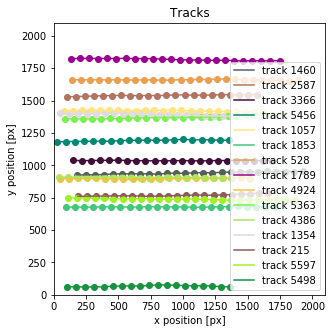

In [0]:
# Data loading
num_time_steps = 28
batch_size = 64
nan_value = 0
belt_width = 2000

fake_data_set = data.FakeDataSet(timesteps=num_time_steps, 
                                 batch_size=batch_size,
                                 number_trajectories=6000, 
                                 additive_noise_stddev=2, 
                                 additive_target_stddev=20,
                                 belt_width=belt_width)

# get tf.Dataset for sequential training
dataset_train, dataset_test = fake_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

fake_data_set.plot_random_tracks(n=15)

25


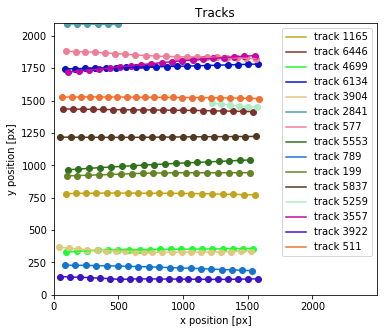

In [0]:
num_time_steps = 40
nan_value = 0
batch_size = 64

csv_data_set = data.CsvDataSet('Pfeffer/trackSortResultPfeffer/*_trackHistory_NothingDeleted.csv',
                              timesteps=num_time_steps, nan_value=nan_value, batch_size=batch_size)

dataset_train, dataset_test = csv_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

csv_data_set.plot_random_tracks(n=15)

In [0]:
for x in dataset_train.take(1):
  data_inp = x[0].numpy()

data_inp.shape

(64, 26, 2)

In [0]:
from pylab import rcParams
from matplotlib.lines import Line2D
rcParams['figure.figsize'] = 20, 10
import matplotlib.colors as mcolors

In [0]:
def get_last_timestep_of_track(track):
  i = None
  for i in range(track.shape[0]):
      if np.all(track[i] == [0., 0.]):
          return i
  return i

data_inp[5, get_last_timestep_of_track(data_inp[5])-1]

array([0.6552752, 0.3894979])

(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)
(64, 1, 2)


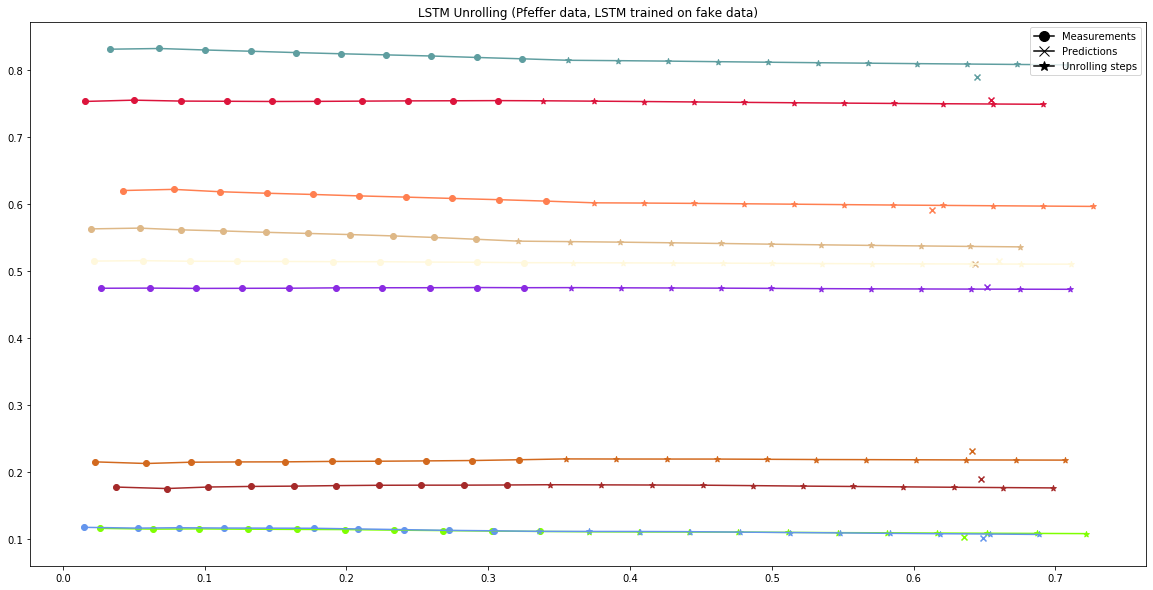

In [0]:
rnn_model.reset_states()

# Create initial positions for particles
tracks = data_inp[:, :1, :]

# for timesteps of real data
real_steps = 10
for t in range(real_steps):
  old_pos = data_inp[:, t:t+1, :]
  new_pos = rnn_model(old_pos).numpy()
  print(new_pos.shape)
  tracks = np.append(tracks, new_pos, axis=1)

# for every timestep 
for t in range(real_steps, real_steps+10):
  old_pos = tracks[:, t:t+1, :]
  print(old_pos.shape)
  new_pos = rnn_model(old_pos).numpy()
  tracks = np.append(tracks, new_pos, axis=1)



# Create the figure
fig, ax = plt.subplots()
ax.title.set_text('LSTM Unrolling (Pfeffer data, LSTM trained on fake data)')
legend_elements = [Line2D([0], [0], marker='o', color='black', label='Measurements', markersize=10),
                   Line2D([0], [0], marker='x', color='black', label='Predictions', markersize=10),
                   Line2D([0], [0], marker='*', color='black', label='Unrolling steps', markersize=10)]
ax.legend(handles=legend_elements)


for t in range(10, 20):
  color = list(mcolors.CSS4_COLORS.keys())[t]
  plt.scatter(tracks[t, :real_steps, 0], tracks[t, :real_steps, 1], c=color)
  plt.scatter(tracks[t, real_steps:, 0], tracks[t, real_steps:, 1], c=color, marker='*')
  plt.plot(tracks[t, :, 0], tracks[t, :, 1], c=color)
  last_pos = data_inp[t, get_last_timestep_of_track(data_inp[t])-1]
  plt.scatter(last_pos[0], last_pos[1], c=color, marker='x')



